In [1]:
# общие
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict
import statistics

# мои
from aggregations import count, describe_numeric, mean, median, top_n
from attribute_manager import add_field
from dataset_helpers import apply_aggregation, filter_data, group_by_attributes
import core
from typing import Any, Dict, List, Optional

In [2]:
print("Загрузка данных из АПИ...")
laureates_data = core.load_data()
print(f"Загружено {len(laureates_data)} записей")

Загрузка данных из АПИ...
Загружено 1018 записей


##### Функции для анализа данных

In [11]:
def filter_by_num_prizes(data: List[Dict], min_prizes: int = 1, max_prizes: int = None) -> List[Dict]:
    """
    функция фильтрует лауреатов по количеству призов
    
    Args:
        data: список лауреатов
        min_prizes: минимальное количество призов
        max_prizes: максимальное количество призов 
    
    Returns:
        отфильтрованный список
    """
    filtered = []
    for item in data:
        num_prizes = len(item.get('prizes_relevant', []))
        if num_prizes >= min_prizes:
            if max_prizes is None or num_prizes <= max_prizes:
                filtered.append(item)
    return filtered


def output_metric_by_category(data: List[Dict], metric_func: callable, metric_name: str = "metric") -> Dict[str, Any]:
    """
    категоризация по призам
    
    Args:
        data: список лауреатов
        metric_func: функция для вычисления метрики
        metric_name: название метрики для вывода
    
    Returns:
        словарь с метриками по категориям
    """
    #группировка призов
    category_data = defaultdict(list)
    
    for item in data:
        prizes = item.get('prizes_relevant', [])
        for prize in prizes:
            category = prize.get('category_en')
            if category:
                metric_value = metric_func(item, prize)
                if metric_value is not None:
                    category_data[category].append(metric_value)
    
    #агрегация
    result = {}
    for category, values in category_data.items():
        if values:
            result[category] = {
                'count': len(values),
                'mean': statistics.mean(values),
                'median': statistics.median(values) if len(values) > 1 else values[0]
            }
    
    print(f"{metric_name} по категориям:")
    for category, stats in sorted(result.items()):
        print(f"  {category}: {stats['mean']:.1f} (n={stats['count']})")
    
    return result


def add_migration_field(data: List[Dict]) -> List[Dict]:
    """для анализа миграции"""
    def get_country_of_origin(item: Dict) -> str:
        if item.get('type_') == 'person':
            return item.get('country_birth')
        elif item.get('type_') == 'organization':
            return item.get('country_founded')
        return None
    
    for item in data:
        item['country_of_origin_adjusted'] = get_country_of_origin(item)
        item['has_migrated'] = (
            item.get('country_of_origin_adjusted') and 
            item.get('country_now') and
            item['country_of_origin_adjusted'] != item['country_now']
        )
    
    return data


def get_first_prize_age(item, prize):
    """возраст при первом призе"""
    if item.get('type_') != 'person':
        return None

    birth_year = item.get('birth_year')
    prize_year = prize.get('award_year')

    if birth_year and prize_year and prize_year > birth_year:
        return prize_year - birth_year
    return None  


def analyze_multiple_laureates(data: List[Dict]):
    """мультилауреаты"""
    print(f"Всего лауреатов: {len(data)}")
    data_with_migration = add_migration_field(data)
    
    multi_laureates = [item for item in data_with_migration if len(item.get('prizes_relevant', [])) >= 2]
    print(f"Лауреатов с ≥2 призами: {len(multi_laureates)}")
    
    super_multi = [item for item in data_with_migration if len(item.get('prizes_relevant', [])) >= 3]
    
    two_time_laureates = [item for item in data_with_migration if len(item.get('prizes_relevant', [])) == 2]
    
    same_category_count = 0
    time_differences = []
    same_category_laureates = [] 
    different_category_laureates = []
    
    for laureate in two_time_laureates:
        prizes = sorted(laureate.get('prizes_relevant', []), key=lambda x: x.get('award_year', 0))
        
        if len(prizes) >= 2:
            first_prize = prizes[0]
            second_prize = prizes[1]
            
            if first_prize.get('category_en') == second_prize.get('category_en'):
                same_category_count += 1
                same_category_laureates.append(laureate.get('name', 'Неизвестно')) # Добавляем имя
            else:
                different_category_laureates.append(laureate.get('name', 'Неизвестно')) # Добавляем имя
            
            year1 = first_prize.get('award_year')
            year2 = second_prize.get('award_year')
            if year1 and year2:
                time_differences.append(year2 - year1)
    
    print("\n--- Имена лауреатов ---")
    print(f"\nВсе мульти-лауреаты (2+ приза):")
    for laureate in multi_laureates:
        print(f"  - {laureate.get('name', 'Неизвестно')} (Количество призов: {len(laureate.get('prizes_relevant', []))})")
    
    print(f"\nСупер-мульти лауреаты (3+ приза):")
    for laureate in super_multi:
        print(f"  - {laureate.get('name', 'Неизвестно')} (Количество призов: {len(laureate.get('prizes_relevant', []))})")
    
    print(f"\nДважды лауреаты, награжденные в одной категории:")
    for name in same_category_laureates:
        print(f"  - {name}")
    
    print(f"\nДважды лауреаты, награжденные в разных категориях:")
    for name in different_category_laureates:
        print(f"  - {name}")

    prize_counts = [len(item.get('prizes_relevant', [])) for item in data_with_migration if item.get('type_') == 'person']
    prize_counts = [pc for pc in prize_counts if pc >= 2]  
    
    if prize_counts:
        counter = Counter(prize_counts)
        counts, freqs = zip(*sorted(counter.items()))
        
        plt.figure(figsize=(10, 6))
        plt.bar(counts, freqs)
        plt.title('Распределение лауреатов по количеству призов (2+)')
        plt.xlabel('Количество призов')
        plt.ylabel('Количество лауреатов')
        plt.show()
    
    if time_differences:
        plt.figure(figsize=(10, 6))
        plt.hist(time_differences, bins=20, edgecolor='black')
        plt.title('Распределение времени между первым и вторым призом')
        plt.xlabel('Количество лет между призами')
        plt.ylabel('Частота')
        plt.show()
    
    different_category_count = len(two_time_laureates) - same_category_count
    labels = ['Одна категория', 'Разные категории']
    sizes = [same_category_count, different_category_count]
    colors = ['lightblue', 'lightcoral']
    
    if same_category_count > 0 or different_category_count > 0:
        plt.figure(figsize=(8, 6))
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        plt.title('Распределение дважды награжденных по смене категории')
        plt.show()



# 1. Дважды и более лауреаты

Всего лауреатов: 1018
Лауреатов с ≥2 призами: 7

--- Имена лауреатов ---

Все мульти-лауреаты (2+ приза):
  - Frederick Sanger (Количество призов: 2)
  - International Committee of the Red Cross (Количество призов: 3)
  - John Bardeen (Количество призов: 2)
  - K. Barry Sharpless (Количество призов: 2)
  - Linus Pauling (Количество призов: 2)
  - Marie Curie (Количество призов: 2)
  - Office of the United Nations High Commissioner for Refugees (Количество призов: 2)

Супер-мульти лауреаты (3+ приза):
  - International Committee of the Red Cross (Количество призов: 3)

Дважды лауреаты, награжденные в одной категории:
  - Frederick Sanger
  - John Bardeen
  - K. Barry Sharpless
  - Office of the United Nations High Commissioner for Refugees

Дважды лауреаты, награжденные в разных категориях:
  - Linus Pauling
  - Marie Curie


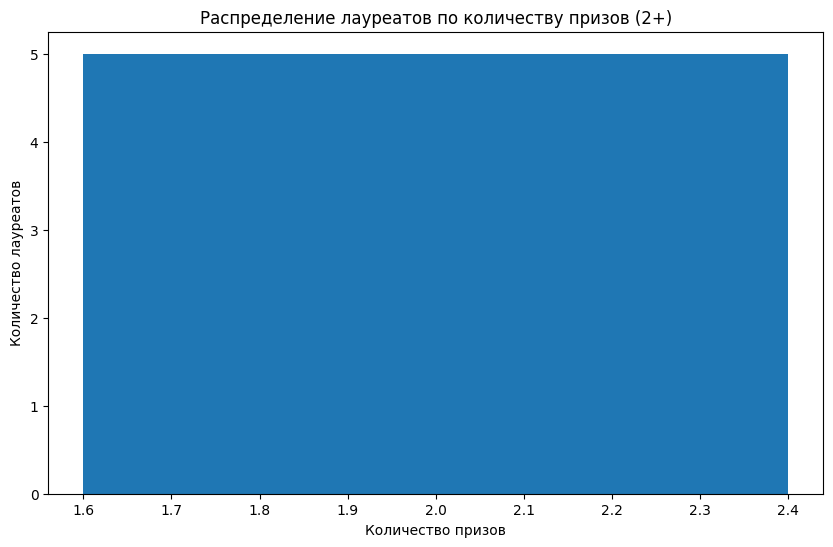

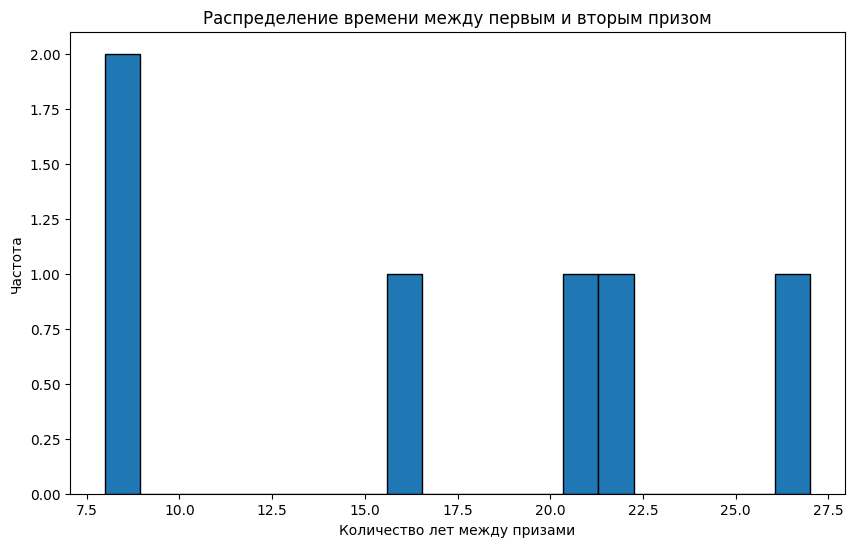

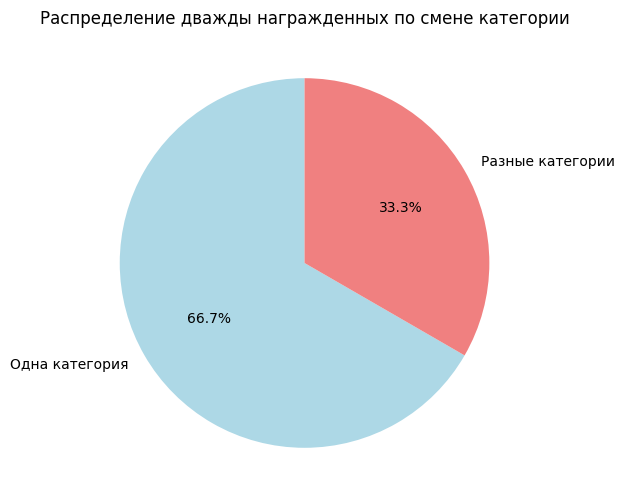

In [12]:
analyze_multiple_laureates(laureates_data)

# 2.Анализ по странам

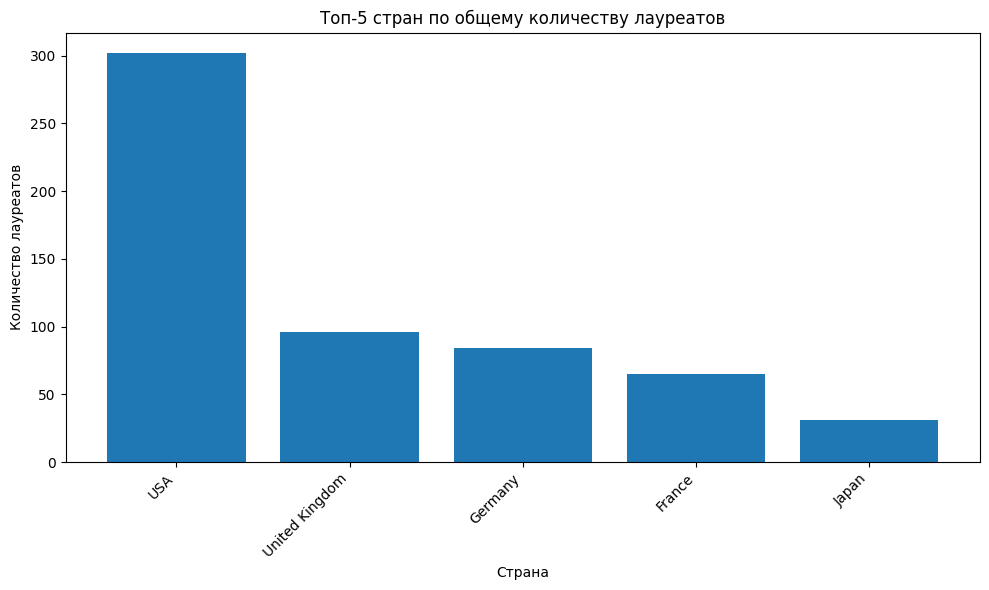

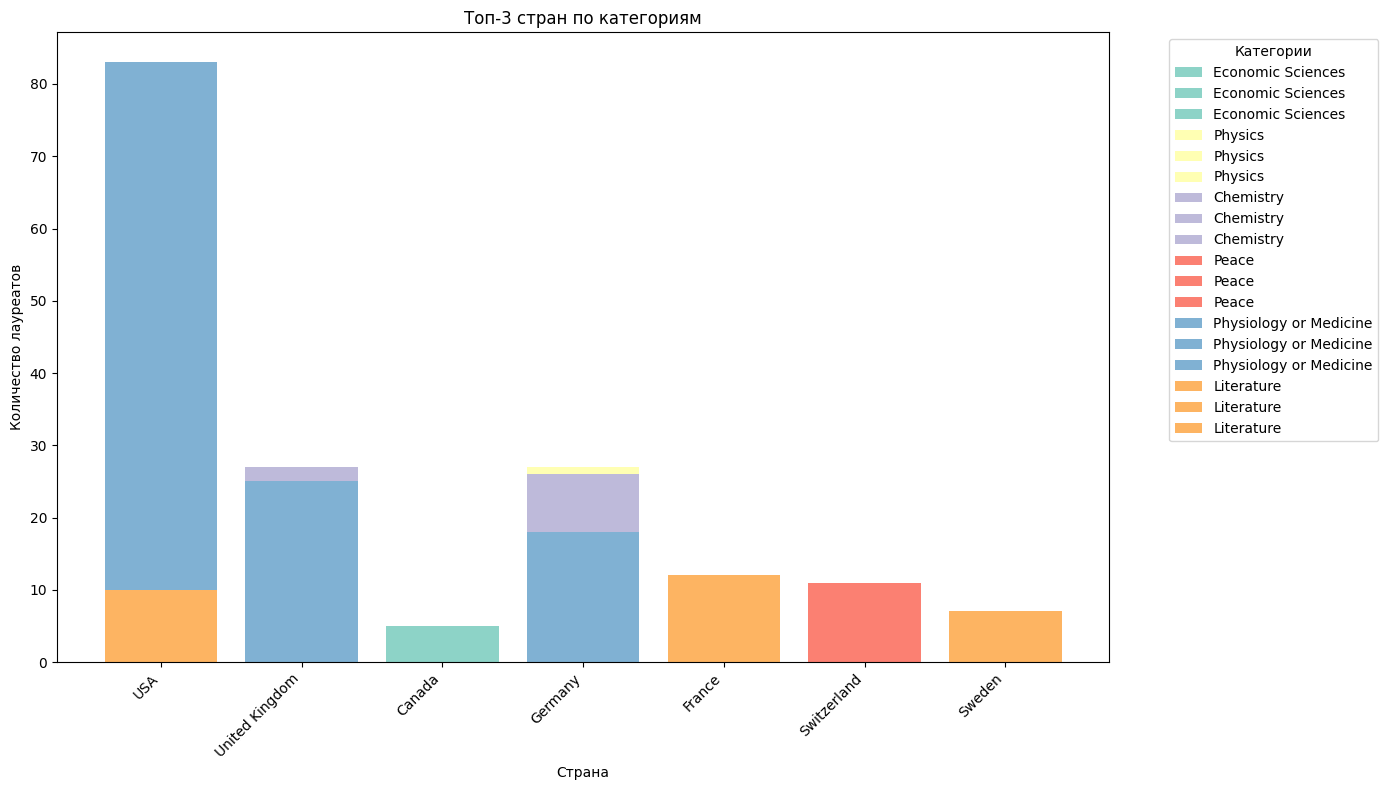

In [4]:
data_with_migration = add_migration_field(laureates_data)

all_countries = []
for item in data_with_migration:
    country = item.get('country_now') or item.get('country_of_origin_adjusted')
    if country:
        all_countries.append(country)

country_counts = Counter(all_countries)
top_countries = country_counts.most_common(5)

if top_countries:
    countries, counts = zip(*top_countries)
    plt.figure(figsize=(10, 6))
    plt.bar(countries, counts)
    plt.title('Топ-5 стран по общему количеству лауреатов')
    plt.xlabel('Страна')
    plt.ylabel('Количество лауреатов')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Сбор данных по категориям
category_country_data = {}
for item in data_with_migration:
    prizes = item.get('prizes_relevant', [])
    country = item.get('country_now') or item.get('country_of_origin_adjusted')
    for prize in prizes:
        category = prize.get('category_en')
        if category and country:
            if category not in category_country_data:
                category_country_data[category] = []
            category_country_data[category].append(country)

fig, ax = plt.subplots(figsize=(14, 8))

all_categories = []
all_countries_plot = []
all_counts_plot = []
colors = plt.cm.Set3(range(len(category_country_data)))

bottom = [0] * len(set(c for countries in category_country_data.values() for c in Counter(countries).most_common(3)[0] if Counter(countries).most_common(3)))

current_bottom = {}
for idx, (category, countries) in enumerate(category_country_data.items()):
    cat_country_counts = Counter(countries)
    top_3 = cat_country_counts.most_common(3)
    
    for country, count in top_3:
        all_categories.append(category)
        all_countries_plot.append(country)
        all_counts_plot.append(count)
        ax.bar(country, count, label=category, bottom=0, color=colors[idx])

ax.set_title('Топ-3 стран по категориям')
ax.set_xlabel('Страна')
ax.set_ylabel('Количество лауреатов')
ax.legend(title='Категории', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 3.Анализ по возрастам

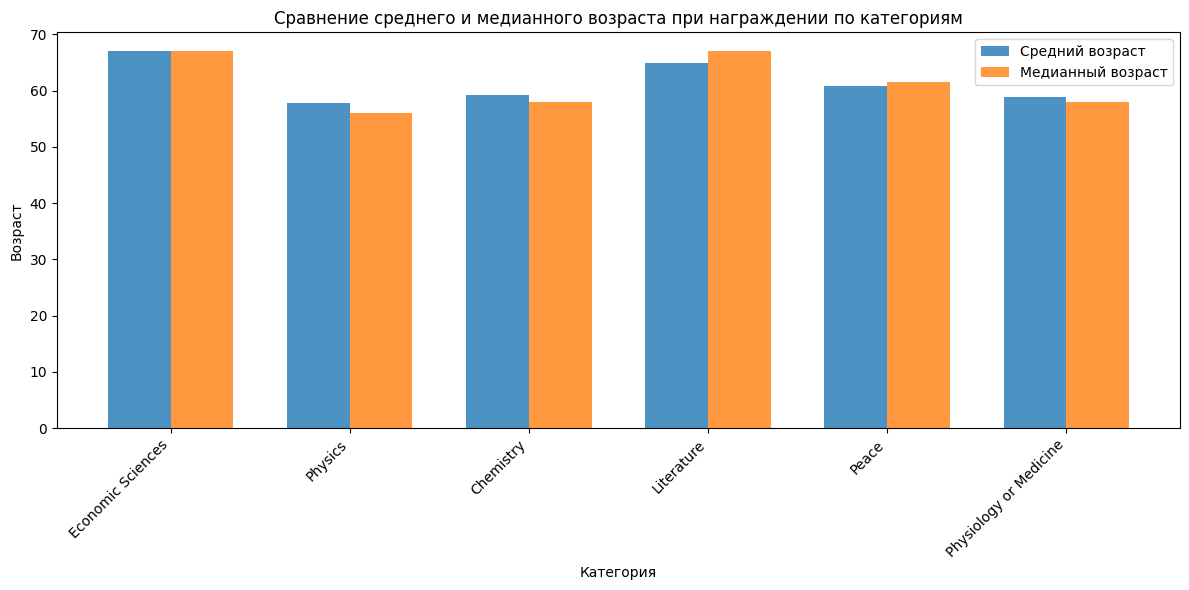

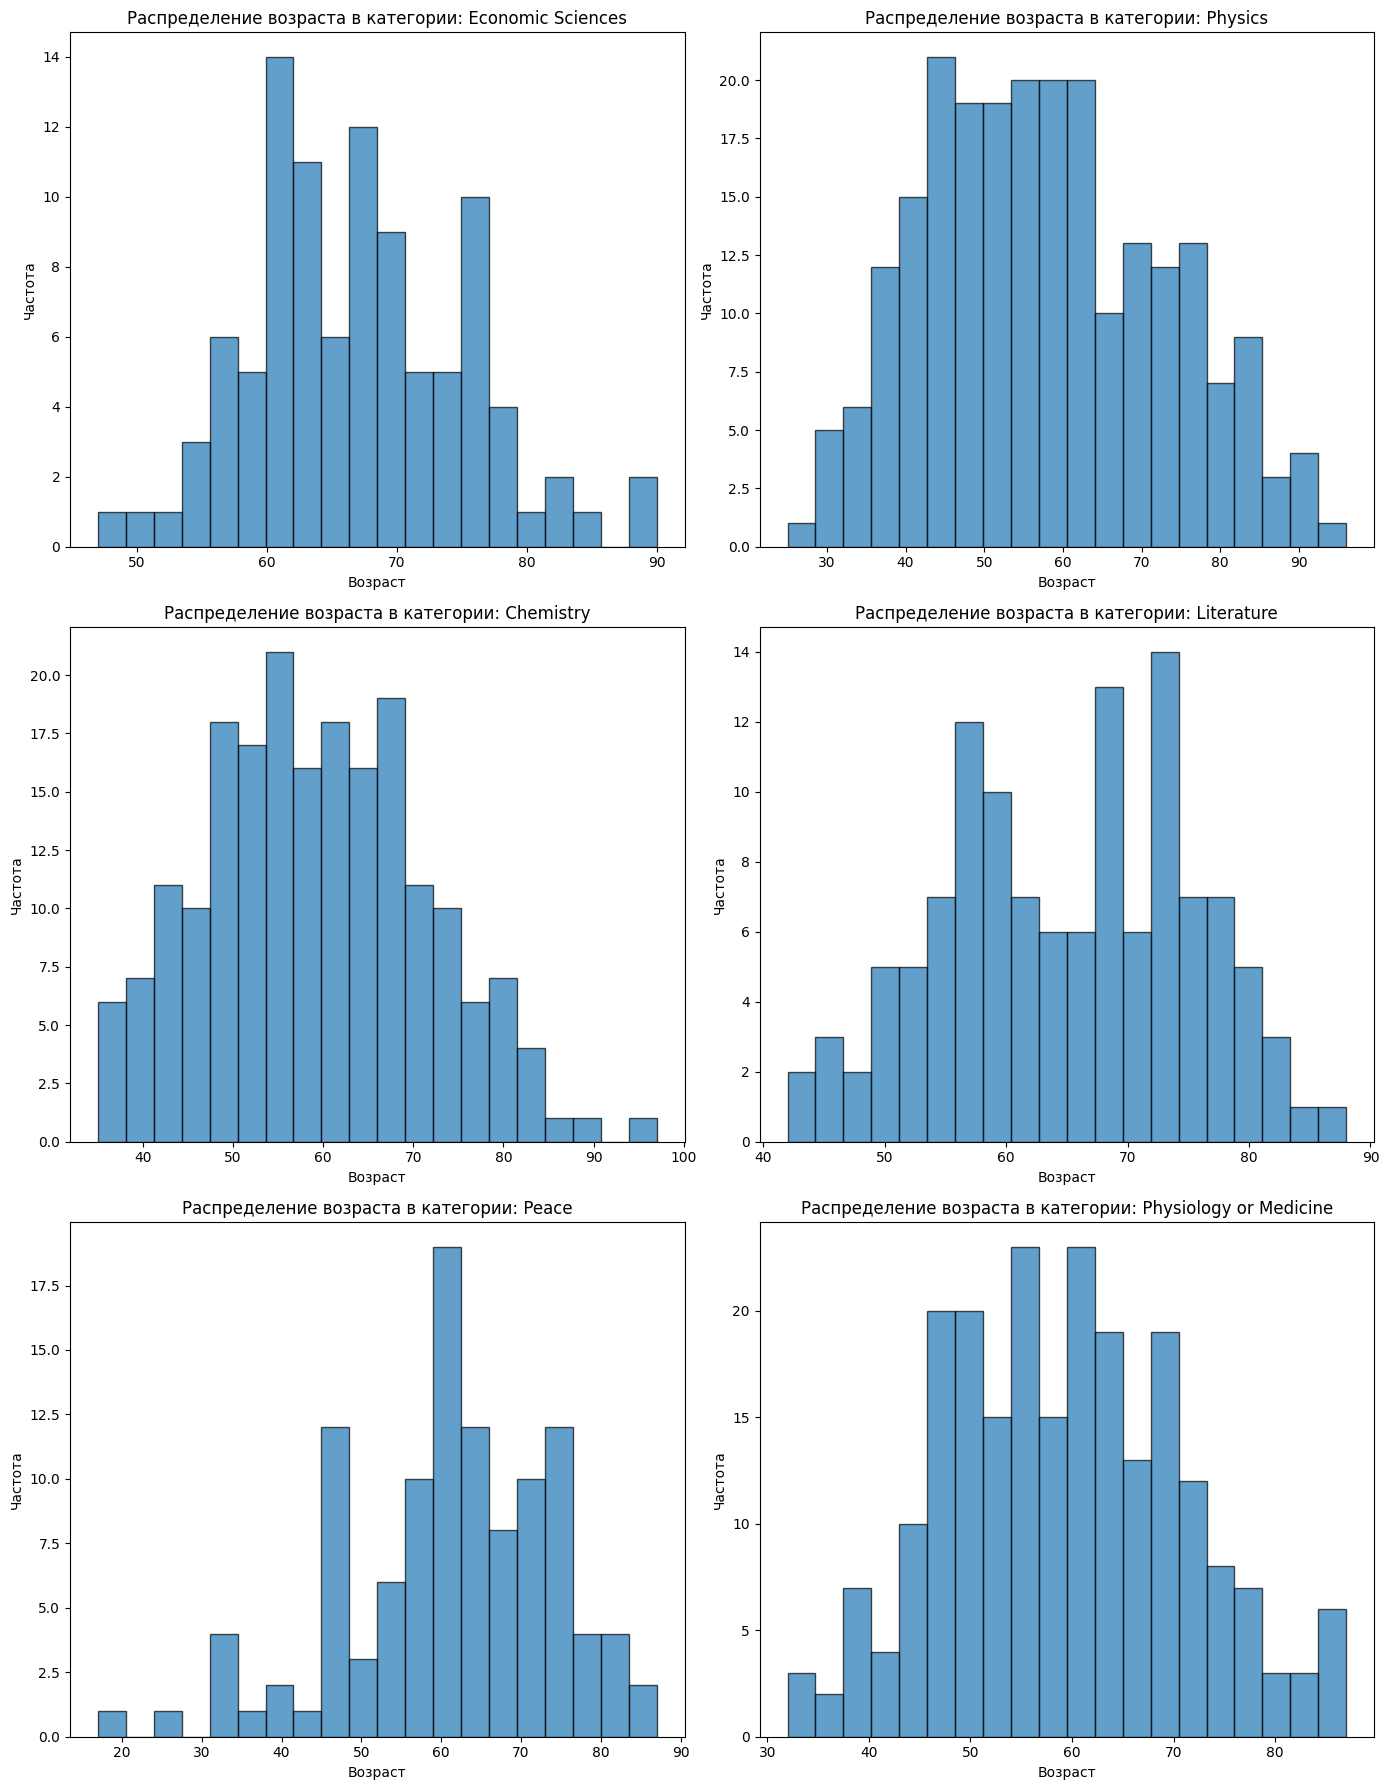

In [5]:
age_by_category = defaultdict(list)
for item in laureates_data:
    prizes = item.get('prizes_relevant', [])
    for prize in prizes:
        age = get_first_prize_age(item, prize)
        if age is not None:
            category = prize.get('category_en')
            if category:
                age_by_category[category].append(age)

category_stats = {}
for category, ages in age_by_category.items():
    mean_age = sum(ages) / len(ages)
    median_age = statistics.median(ages)
    category_stats[category] = {'mean': mean_age, 'median': median_age}                

categories = list(category_stats.keys())
mean_ages = [stats['mean'] for stats in category_stats.values()]
median_ages = [stats['median'] for stats in category_stats.values()]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, mean_ages, width, label='Средний возраст', alpha=0.8)
ax.bar(x + width/2, median_ages, width, label='Медианный возраст', alpha=0.8)

ax.set_xlabel('Категория')
ax.set_ylabel('Возраст')
ax.set_title('Сравнение среднего и медианного возраста при награждении по категориям')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()

# Гистограммы распределения возраста для каждой категории
n_categories = len(category_stats)
if n_categories > 0:
    cols = 2
    rows = (n_categories + 1) // 2
    fig, axes = plt.subplots(rows, cols, figsize=(14, 6 * rows))
    if rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()
    
    for idx, (category, ages) in enumerate(age_by_category.items()):
        axes[idx].hist(ages, bins=20, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Распределение возраста в категории: {category}')
        axes[idx].set_xlabel('Возраст')
        axes[idx].set_ylabel('Частота')
    
    # Скрыть пустые подграфики
    for idx in range(len(age_by_category), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# 4. Гендерный анализ

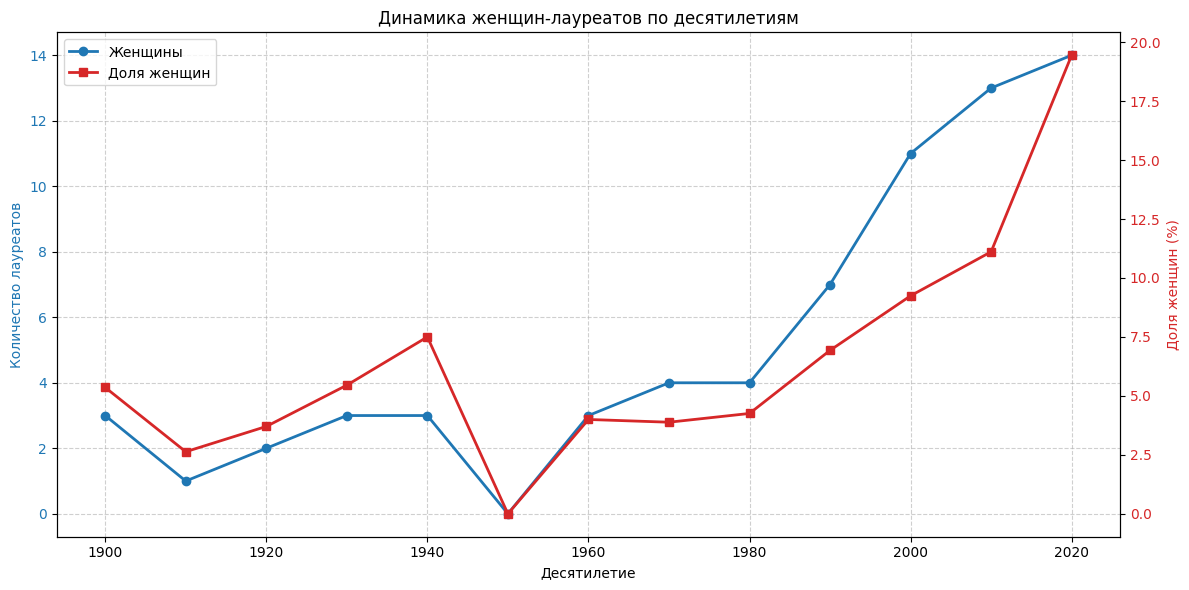

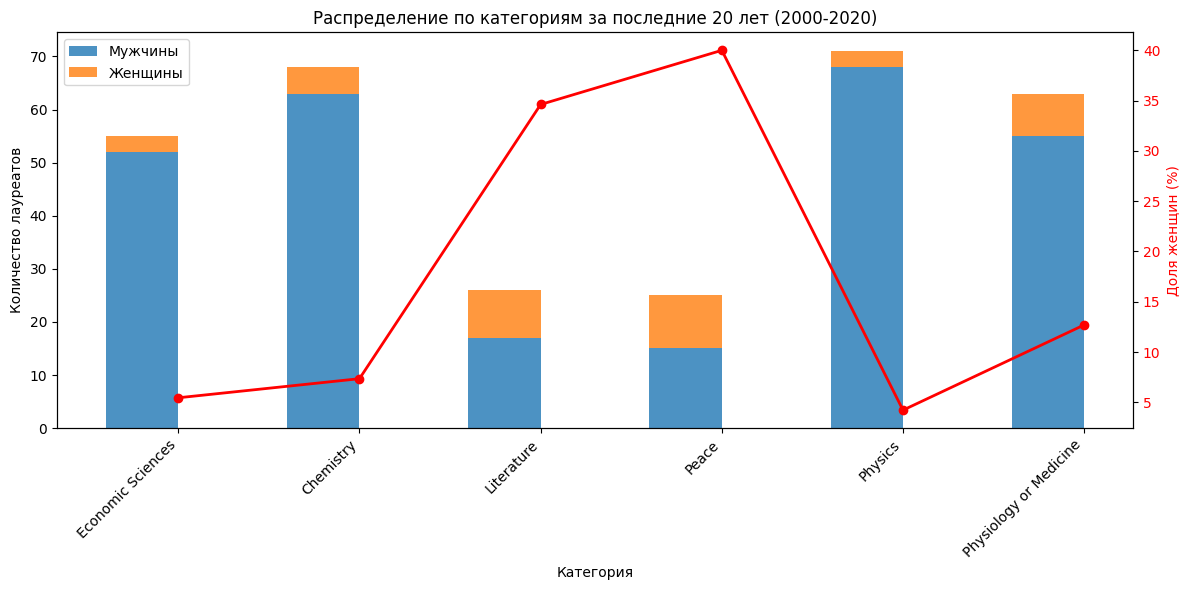

In [9]:
decade_gender_data = defaultdict(lambda: defaultdict(int))

for item in laureates_data:
    if item.get('type_') != 'person':
        continue
        
    gender = item.get('gender')
    prizes = item.get('prizes_relevant', [])
    
    for prize in prizes:
        year = prize.get('award_year')
        if year and gender:
            decade = (year // 10) * 10
            decade_gender_data[decade][gender] += 1
            decade_gender_data[decade]['total'] += 1

for decade in sorted(decade_gender_data.keys()):
    women = decade_gender_data[decade].get('female', 0)
    total = decade_gender_data[decade].get('total', 0)
    percentage = (women / total * 100) if total > 0 else 0

decades = sorted(decade_gender_data.keys())
women_counts = [decade_gender_data[d].get('female', 0) for d in decades]
total_counts = [decade_gender_data[d].get('total', 0) for d in decades]
percentages = [(w / t * 100) if t > 0 else 0 for w, t in zip(women_counts, total_counts)]

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Десятилетие')
ax1.set_ylabel('Количество лауреатов', color=color)
line1 = ax1.plot(decades, women_counts, label='Женщины', marker='o', color=color, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Доля женщин (%)', color=color)
line2 = ax2.plot(decades, percentages, label='Доля женщин', marker='s', color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_title('Динамика женщин-лауреатов по десятилетиям')
ax1.grid(True, linestyle='--', alpha=0.6)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

recent_data = [item for item in laureates_data if item.get('type_') == 'person' and any(prize.get('award_year', 0) >= 2000 for prize in item.get('prizes_relevant', []))]

category_gender_recent = defaultdict(lambda: defaultdict(int))
for item in recent_data:
    gender = item.get('gender')
    prizes = item.get('prizes_relevant', [])
    
    for prize in prizes:
        if prize.get('award_year', 0) >= 2000:
            category = prize.get('category_en')
            if category and gender:
                category_gender_recent[category][gender] += 1

categories_recent = []
women_recent = []
total_recent = []
percentages_recent = []

for category, genders in category_gender_recent.items():
    women = genders.get('female', 0)
    total = sum(genders.values())
    percentage = (women / total * 100) if total > 0 else 0
    categories_recent.append(category)
    women_recent.append(women)
    total_recent.append(total)
    percentages_recent.append(percentage)

if categories_recent:
    x = np.arange(len(categories_recent))
    width = 0.4

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, [t-w for t, w in zip(total_recent, women_recent)], width, label='Мужчины', alpha=0.8)
    ax.bar(x - width/2, women_recent, width, label='Женщины', alpha=0.8, bottom=[t-w for t, w in zip(total_recent, women_recent)])

ax2 = ax.twinx()
ax2.plot(x, percentages_recent, color='red', marker='o', label='Доля женщин (%)', linewidth=2)
ax2.set_ylabel('Доля женщин (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax.set_xlabel('Категория')
ax.set_ylabel('Количество лауреатов')
ax.set_title('Распределение по категориям за последние 20 лет (2000-2020)')
ax.set_xticks(x)
ax.set_xticklabels(categories_recent, rotation=45, ha="right")
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()